# STEP 1: Data Collection


> Choosing 5 stocks (Example: Tech Sector)



In [ ]:
!pip install yfinance streamlit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize
from datetime import datetime



# Step 2: Download Historical Stock Data

In [ ]:
stocks = ['AAPL', 'GOOGL', 'META', 'AMZN', 'MSFT']
start_date = '2010-01-01'
end_date = '2024-12-31'

data = yf.download(stocks, start=start_date, end=end_date,auto_adjust=False)['Adj Close']
returns = data.pct_change().dropna()
log_returns = np.log(data / data.shift(1)).dropna()
log_returns.head()


[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,META,MSFT
Date,,,,,
2012-05-21,0.056626,0.019725,0.022578,-0.116378,0.016266
2012-05-22,-0.007708,-0.012828,-0.021912,-0.093255,0.000336
2012-05-23,0.024107,0.009015,0.014311,0.031749,-0.022083
2012-05-24,-0.009226,-0.009433,-0.009562,0.031680,-0.001376
2012-05-25,-0.005375,-0.010978,-0.020299,-0.034497,-0.000344


# Step 3: Create Two Random Portfolios (with seeds)

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
weights1 = np.random.random(len(stocks))
weights1 /= np.sum(weights1)

np.random.seed(100)
weights2 = np.random.random(len(stocks))
weights2 /= np.sum(weights2)

# Portfolio returns and volatility
def portfolio_performance(weights, returns):
    mean_returns = log_returns.mean()
    cov_matrix = returns.cov()

    port_return = np.dot(weights, mean_returns) * 252
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    sharpe_ratio = port_return / port_volatility

    return port_return, port_volatility, sharpe_ratio


# Step 4: Calculate Performance of Random Portfolios

In [ ]:
ret1, vol1, sharpe1 = portfolio_performance(weights1, log_returns)
ret2, vol2, sharpe2 = portfolio_performance(weights2, log_returns)

print("Random Portfolio 1:")
print("Weights:", dict(zip(stocks, np.round(weights1, 3))))
print(f"Return: {ret1:.2%}, Volatility: {vol1:.2%}, Sharpe Ratio: {sharpe1:.2f}")

print("\nRandom Portfolio 2:")
print("Weights:", dict(zip(stocks, np.round(weights2, 3))))
print(f"Return: {ret2:.2%}, Volatility: {vol2:.2%}, Sharpe Ratio: {sharpe2:.2f}")


Random Portfolio 1:
Weights: {'AAPL': np.float64(0.133), 'GOOGL': np.float64(0.338), 'META': np.float64(0.26), 'AMZN': np.float64(0.213), 'MSFT': np.float64(0.055)}
Return: 22.24%, Volatility: 25.54%, Sharpe Ratio: 0.87

Random Portfolio 2:
Weights: {'AAPL': np.float64(0.259), 'GOOGL': np.float64(0.133), 'META': np.float64(0.203), 'AMZN': np.float64(0.403), 'MSFT': np.float64(0.002)}
Return: 21.81%, Volatility: 26.99%, Sharpe Ratio: 0.81


# Step 5: Optimize Portfolio (Maximize Sharpe Ratio)

In [ ]:
from scipy.optimize import minimize

def neg_sharpe(weights, log_returns):
    return -portfolio_performance(weights, log_returns)[2]  # negative Sharpe

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # sum to 1
bounds = tuple((0, 1) for _ in stocks)  # no short selling
initial_guess = len(stocks) * [1./len(stocks)]

opt_result = minimize(neg_sharpe, initial_guess, args=(log_returns,), method='SLSQP', bounds=bounds, constraints=constraints)
opt_weights = opt_result.x

ret_opt, vol_opt, sharpe_opt = portfolio_performance(opt_weights, log_returns)

print("\nOptimized Portfolio:")
print("Weights:", dict(zip(stocks, np.round(opt_weights, 3))))
print(f"Return: {ret_opt:.2%}, Volatility: {vol_opt:.2%}, Sharpe Ratio: {sharpe_opt:.2f}")



Optimized Portfolio:
Weights: {'AAPL': np.float64(0.277), 'GOOGL': np.float64(0.195), 'META': np.float64(0.09), 'AMZN': np.float64(0.002), 'MSFT': np.float64(0.436)}
Return: 22.67%, Volatility: 23.49%, Sharpe Ratio: 0.96


# Step 6: Compare All Portfolios Visually


Comparison:
   Portfolio    Return  Volatility  Sharpe Ratio
0      Set 1  0.222359    0.255445      0.870478
1      Set 2  0.218069    0.269898      0.807967
2  Optimized  0.226656    0.234914      0.964846


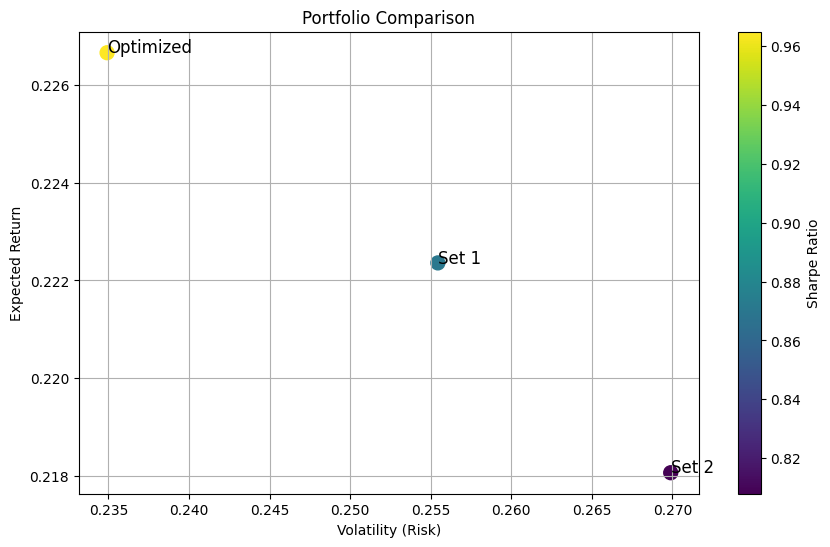

In [ ]:
# Create DataFrame for comparison
compare_df = pd.DataFrame({
    'Portfolio': ['Set 1', 'Set 2', 'Optimized'],
    'Return': [ret1, ret2, ret_opt],
    'Volatility': [vol1, vol2, vol_opt],
    'Sharpe Ratio': [sharpe1, sharpe2, sharpe_opt]
})

print("\nComparison:")
print(compare_df)

# Plotting
plt.figure(figsize=(10,6))
plt.scatter(compare_df['Volatility'], compare_df['Return'], c=compare_df['Sharpe Ratio'], cmap='viridis', s=100)
for i in range(compare_df.shape[0]):
    plt.annotate(compare_df['Portfolio'][i], (compare_df['Volatility'][i], compare_df['Return'][i]), fontsize=12)

plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.title('Portfolio Comparison')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()


# STEP 7: Monte Carlo Simulation – Generate 5000+ random portfolios

In [ ]:
num_portfolios = 5000
all_weights = []
returns_list = []
volatility_list = []
sharpe_list = []

mean_returns = log_returns.mean()
cov_matrix = log_returns.cov()

for _ in range(num_portfolios):
    weights = np.random.random(len(stocks))
    weights /= np.sum(weights)

    port_return = np.dot(weights, mean_returns) * 252
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    sharpe_ratio = port_return / port_volatility

    all_weights.append(weights)
    returns_list.append(port_return)
    volatility_list.append(port_volatility)
    sharpe_list.append(sharpe_ratio)

# Convert to DataFrame
portfolios_df = pd.DataFrame({
    'Return': returns_list,
    'Volatility': volatility_list,
    'Sharpe Ratio': sharpe_list
})

# Add each stock's weight as a column
for i, stock in enumerate(stocks):
    portfolios_df[stock] = [w[i] for w in all_weights]


## Plot Efficient Frontier + Previous 3 Portfolios

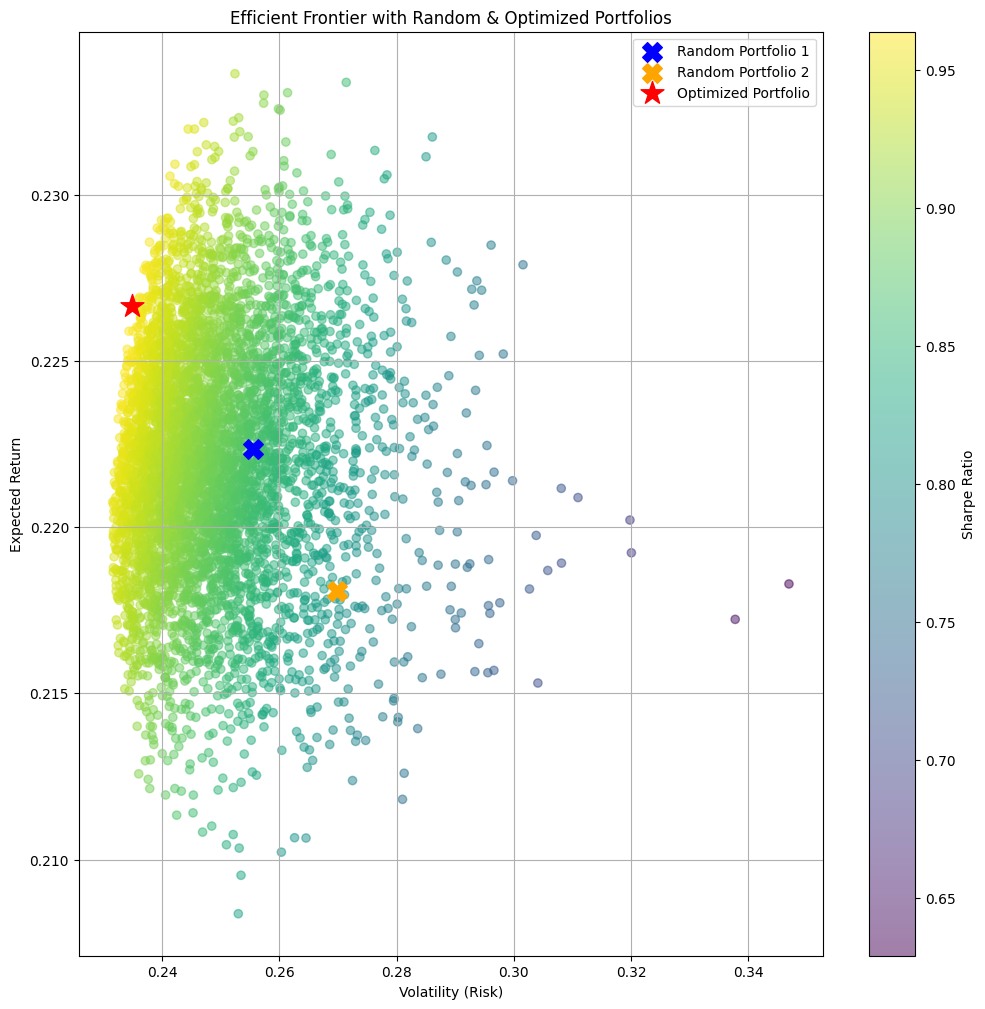

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
sc = plt.scatter(portfolios_df['Volatility'], portfolios_df['Return'],
                 c=portfolios_df['Sharpe Ratio'], cmap='viridis', alpha=0.5)
plt.colorbar(sc, label='Sharpe Ratio')

# Mark Random Portfolio 1
plt.scatter(vol1, ret1, color='blue', marker='X', s=200, label='Random Portfolio 1')

# Mark Random Portfolio 2
plt.scatter(vol2, ret2, color='orange', marker='X', s=200, label='Random Portfolio 2')

# Mark Optimized Portfolio
plt.scatter(vol_opt, ret_opt, color='red', marker='*', s=300, label='Optimized Portfolio')

plt.title('Efficient Frontier with Random & Optimized Portfolios')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()


> ## ✅ Conclusion: Monte Carlo Simulation & Efficient Frontier
>
> - A Monte Carlo simulation of over **5000 random portfolios** was performed using daily historical returns.
> - For each portfolio, the **annualized return**, **volatility**, and **Sharpe Ratio** were calculated.
> - The resulting data was visualized as an **Efficient Frontier**, with each point representing a possible portfolio.
> - The two seeded **random portfolios** and the **optimized portfolio** were distinctly plotted on this frontier.
> - Sharpe Ratios were represented through color intensity, offering an immediate visual insight into portfolio efficiency.
> - This enhancement allowed for a **broader view of the risk-return space**, illustrating how optimal the calculated portfolios are relative to thousands of others.
> - A solid foundation was laid for deeper discussions on **diversification, portfolio efficiency**, and **risk-reward tradeoffs**.


# Step 8: Adding the Capital Market Line (CML)

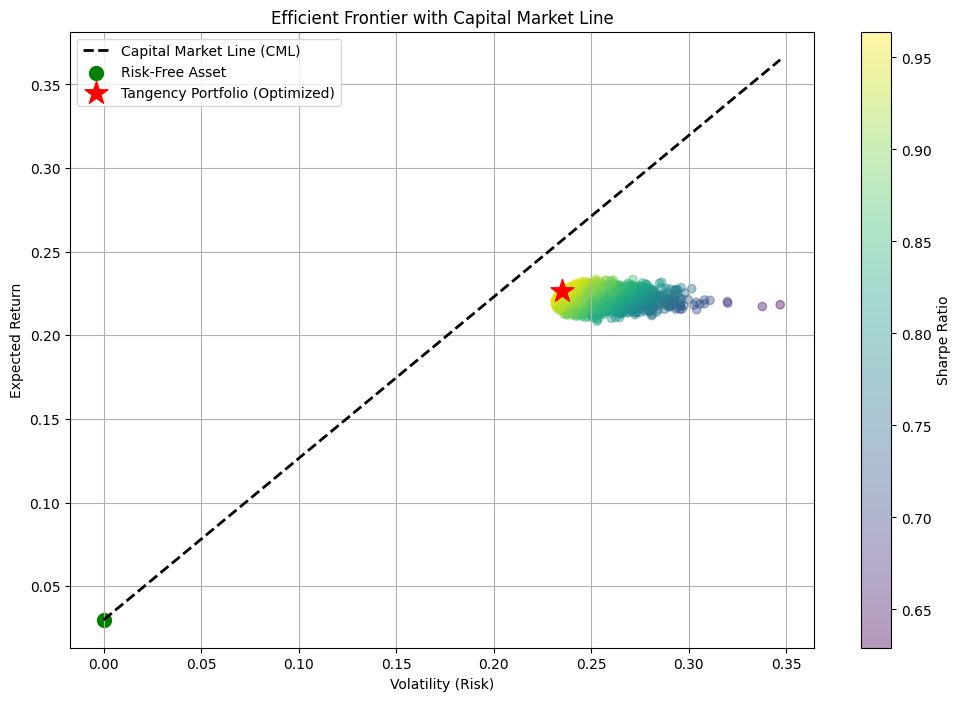

In [ ]:
# Risk-free rate (example: 3% annually)
risk_free_rate = 0.03

# Generate x-axis (volatility) values for the line
cml_x = np.linspace(0, max(volatility_list), 100)
# Calculate y = rf + Sharpe_max * x
cml_y = risk_free_rate + sharpe_opt * cml_x

# Re-plot the efficient frontier with CML
plt.figure(figsize=(12, 8))
sc = plt.scatter(portfolios_df['Volatility'], portfolios_df['Return'],
                 c=portfolios_df['Sharpe Ratio'], cmap='viridis', alpha=0.4)
plt.colorbar(sc, label='Sharpe Ratio')

# Plot CML
plt.plot(cml_x, cml_y, color='black', linestyle='--', linewidth=2, label='Capital Market Line (CML)')

# Plot risk-free point
plt.scatter(0, risk_free_rate, color='green', marker='o', s=100, label='Risk-Free Asset')

# Plot optimized (tangency) portfolio
plt.scatter(vol_opt, ret_opt, color='red', marker='*', s=300, label='Tangency Portfolio (Optimized)')

plt.title('Efficient Frontier with Capital Market Line')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()


> ## ✅ Conclusion: Capital Market Line (CML)
>
> - The **Capital Market Line** (CML) was added to the Efficient Frontier to visually represent the optimal portfolios combining a **risk-free asset** and the **market portfolio**.
> - The CML starts from the **risk-free rate (e.g., 3%)** on the Y-axis and is tangent to the efficient frontier at the **optimized portfolio** (maximum Sharpe Ratio).
> - This highlights the **tangency portfolio**, which lies at the point of **maximum reward per unit of risk**.
> - The CML illustrates that all portfolios lying on this line are **efficient combinations** of the risk-free asset and the optimal risky portfolio.
> - As a result, the concept of **risk-adjusted returns** and the geometric interpretation of the **Sharpe Ratio** was strengthened.


| Location          | Meaning                                                                                                                                                                                                                                         |
|-------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **On the CML**    | ✅ The portfolio is considered **efficient** — the **maximum return for the given level of risk** is being achieved. This includes the **tangency portfolio** and any portfolio formed as a blend with the **risk-free asset**.                  |
| **Below the CML** | ⚠️ The portfolio is considered **inefficient** — a **lower Sharpe Ratio** is being achieved compared to the market/tangency portfolio. An **insufficient reward for the risk taken** is being received.                                        |
| **Above the CML** | ❌ This situation is considered **theoretically impossible** in efficient markets. If it lies above the CML, a **Sharpe Ratio greater than that of the market portfolio** is being implied, violating optimal portfolio theory. This is caused by data errors, incorrect assumptions, or overfitting. |


# STEP 9: Enhancement 4: Add Real Financial Metrics

In [ ]:
# ----------------------------
# Enhancement 4: Risk Metrics
# ----------------------------

import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Download S&P 500 (SPY) for market comparison
spy = yf.download('SPY', start=start_date, end=end_date, auto_adjust=False)['Adj Close']
spy_returns = spy.pct_change().dropna()

# Align dates between portfolio and SPY returns
common_dates = log_returns.index.intersection(spy_returns.index)
aligned_returns = log_returns.loc[common_dates]
aligned_spy = spy_returns.loc[common_dates]

# Compute daily portfolio returns
opt_daily_returns = aligned_returns.dot(opt_weights)

# ----------------------------
# Beta & Alpha
# ----------------------------
opt_returns_array = opt_daily_returns.values.flatten()
spy_returns_array = aligned_spy.values.flatten()

cov = np.cov(opt_returns_array, spy_returns_array)
beta = cov[0, 1] / cov[1, 1]

# Annualized Alpha
alpha = (opt_daily_returns.mean() - risk_free_rate / 252) - beta * (aligned_spy.mean() - risk_free_rate / 252)
alpha *= 252  # Annualize

# ----------------------------
# Max Drawdown
# ----------------------------
cum_returns = (1 + opt_daily_returns).cumprod()
rolling_max = cum_returns.cummax()
drawdown = (cum_returns - rolling_max) / rolling_max
max_drawdown = drawdown.min()

# ----------------------------
# Sortino Ratio
# ----------------------------
downside_returns = opt_daily_returns[opt_daily_returns < 0]
expected_return = opt_daily_returns.mean() * 252
downside_std = np.std(downside_returns) * np.sqrt(252)
sortino_ratio = (expected_return - risk_free_rate) / downside_std

# ----------------------------
# Print Risk Metrics
# ----------------------------
print("\n\n")
print("Portfolio Risk Metrics (Optimized Portfolio)")
print(f"Beta: {beta:.3f}")
print(f"Alpha (annualized): {alpha.item():.3%}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Sortino Ratio: {sortino_ratio:.3f}")


[*********************100%***********************]  1 of 1 completed




Portfolio Risk Metrics (Optimized Portfolio)
Beta: 1.188
Alpha (annualized): 5.148%
Max Drawdown: -41.73%
Sortino Ratio: 1.097


## Cumulative Returns with Drawdown Overlay

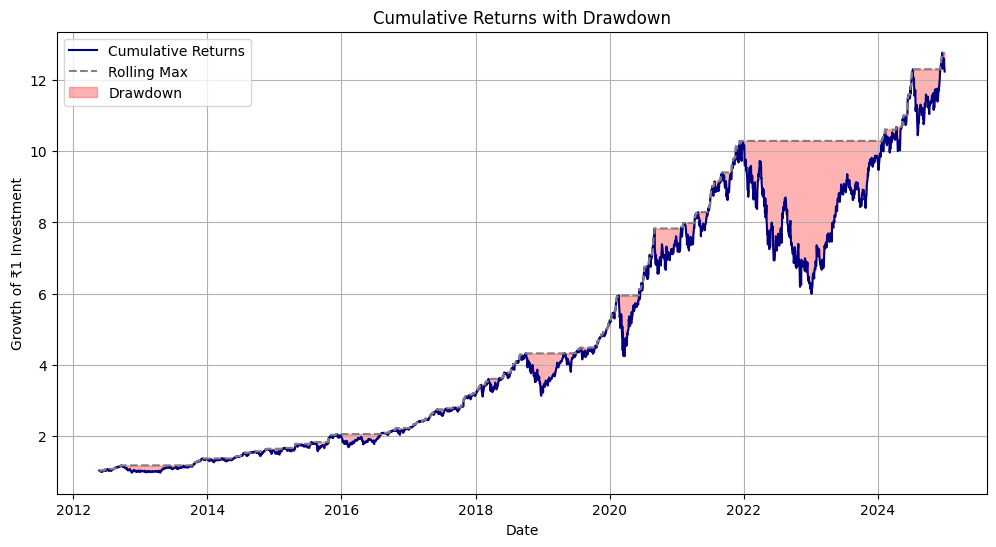

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(cum_returns, label='Cumulative Returns', color='navy')
plt.plot(rolling_max, label='Rolling Max', linestyle='--', color='gray')
plt.fill_between(cum_returns.index, cum_returns, rolling_max, color='red', alpha=0.3, label='Drawdown')

plt.title("Cumulative Returns with Drawdown")
plt.xlabel("Date")
plt.ylabel("Growth of ₹1 Investment")
plt.legend()
plt.grid(True)
plt.show()


 ## Histogram of Daily Returns (for Sortino/Volatility Analysis)

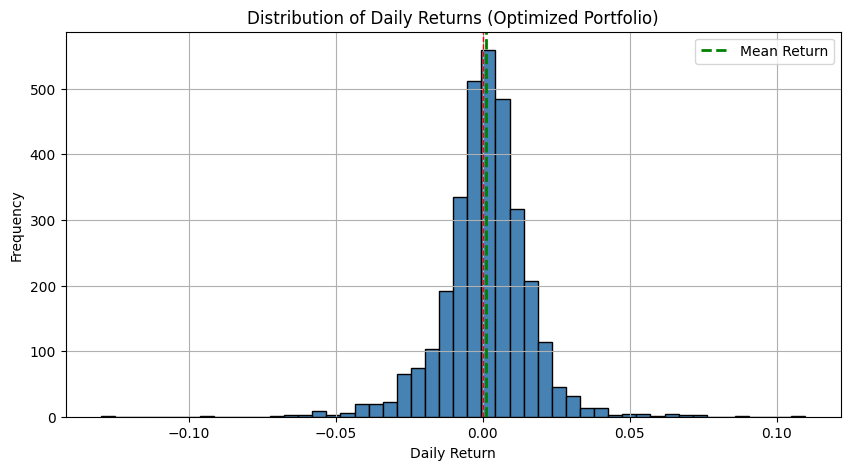

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(opt_daily_returns, bins=50, color='steelblue', edgecolor='black')
plt.axvline(opt_daily_returns.mean(), color='green', linestyle='dashed', linewidth=2, label='Mean Return')
plt.axvline(0, color='red', linestyle='--', linewidth=1)

plt.title("Distribution of Daily Returns (Optimized Portfolio)")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


## Drawdown Timeline (Max Drawdown Detail)

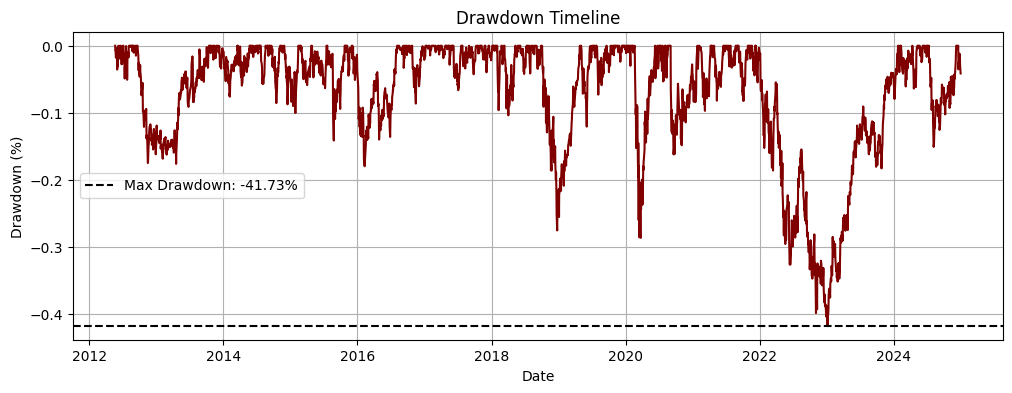

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(drawdown, color='maroon')
plt.axhline(drawdown.min(), linestyle='--', color='black', label=f'Max Drawdown: {max_drawdown:.2%}')
plt.title("Drawdown Timeline")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.grid(True)
plt.legend()
plt.show()


## Scatter: Portfolio Return vs. SPY Return (Beta/Alpha Analysis)


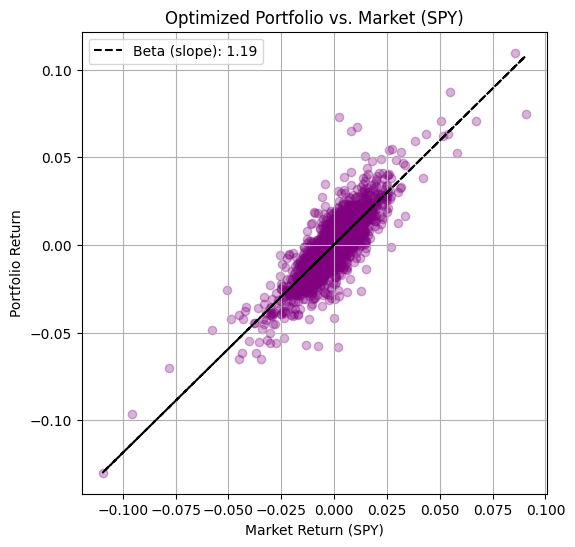

In [ ]:
# Ensure both are clean 1D NumPy arrays
x = spy_returns.loc[opt_daily_returns.index].to_numpy().flatten()
y = opt_daily_returns.to_numpy().flatten()

# Fit linear regression line: y = m*x + b
m, b = np.polyfit(x, y, 1)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(x, y, alpha=0.3, color='purple')
plt.plot(x, m * x + b, color='black', linestyle='--', label=f'Beta (slope): {m:.2f}')
plt.title("Optimized Portfolio vs. Market (SPY)")
plt.xlabel("Market Return (SPY)")
plt.ylabel("Portfolio Return")
plt.legend()
plt.grid(True)
plt.show()


> ## ✅ Conclusion: Real Financial Metrics
>
> - A set of professional financial metrics were calculated for the **optimized portfolio**, providing a more comprehensive risk-return profile.
> - The **Beta** was used to assess how the portfolio responds to general market movements, with values >1 indicating more sensitivity.
> - The **Alpha** was calculated to determine the excess return relative to the market, adjusting for risk.
> - The **Maximum Drawdown** revealed the largest observed loss from a portfolio peak, offering a view of downside risk over time.
> - The **Sortino Ratio** improved upon the Sharpe Ratio by penalizing only the downside volatility, making it more reliable for assessing true performance.
> - With these metrics, the portfolio was analyzed beyond basic return and volatility, using industry-standard tools for performance evaluation.


# STEP 10 Adding Rebalancing Strategies (Monthly, Quarterly, etc.)

In [ ]:
# Ensure index is datetime
log_returns.index = pd.to_datetime(log_returns.index)

# Simulate Buy-and-Hold Strategy
bh_cum_returns = (1 + log_returns.dot(opt_weights)).cumprod()

# Simulate Monthly Rebalancing Strategy
rebalance_dates = log_returns.resample('M').first().index

rebalanced_values = []
current_value = 1
last_rebalance_day = log_returns.index[0]

for rebalance_day in rebalance_dates:
    # Slice returns between two rebalances
    period_returns = log_returns.loc[last_rebalance_day:rebalance_day]

    if period_returns.empty:
        continue

    # Apply weights from optimization
    daily_returns = period_returns.dot(opt_weights)
    period_growth = (1 + daily_returns).cumprod()

    # Scale by current value
    period_growth *= current_value
    current_value = period_growth[-1]

    rebalanced_values.append(period_growth)
    last_rebalance_day = rebalance_day

# Concatenate all periods
rebalance_cum_returns = pd.concat(rebalanced_values)

# Align for plotting
aligned = pd.DataFrame({
    'Buy and Hold': bh_cum_returns,
    'Monthly Rebalanced': rebalance_cum_returns
}).dropna()


/tmp/ipython-input-15-1926965922.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_dates = log_returns.resample('M').first().index
/tmp/ipython-input-15-1926965922.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_value = period_growth[-1]


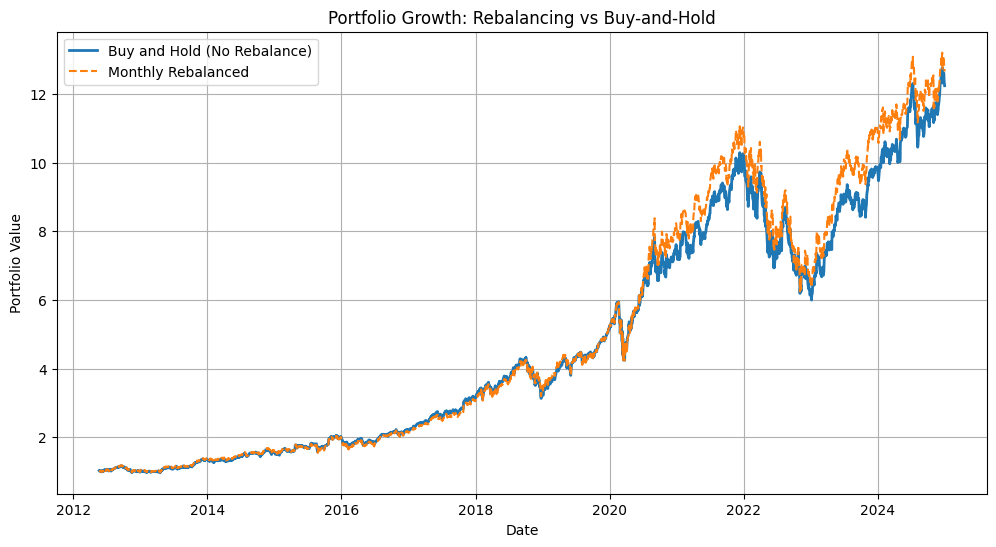

In [ ]:


plt.figure(figsize=(12, 6))
plt.plot(aligned['Buy and Hold'], label='Buy and Hold (No Rebalance)', linewidth=2)
plt.plot(aligned['Monthly Rebalanced'], label='Monthly Rebalanced', linestyle='--')
plt.title("Portfolio Growth: Rebalancing vs Buy-and-Hold")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()


> ## ✅ Conclusion for Enhancement 5: Rebalancing Strategies
>
> - A **rebalancing mechanism** was implemented to simulate periodic adjustment of portfolio weights back to the optimized allocation.
> - Two strategies were compared:
>   - **Buy-and-Hold**: Letting weights drift based on market performance.
>   - **Monthly Rebalanced**: Resetting weights at the start of each month.
> - The **monthly rebalanced portfolio** offered more consistent alignment with the desired risk-return profile, though sometimes at the cost of transaction-based return drag.
> - By including rebalancing logic, the simulation became more **realistic and reflective of actual portfolio management** practices.
> - The analysis allows investors to evaluate whether rebalancing improves returns, reduces risk, or enhances stability.


# STEP 11: Improve Accuracy with Log Returns, Covariance Shrinkage & Inflation Adjustment


>  Goal:
- Increase the accuracy and robustness of portfolio calculations by:
- Using log returns (more realistic for compounding behavior)
- Applying covariance shrinkage to reduce estimation error (Ledoit-Wolf method)
- Adjusting returns for inflation (real returns)



## Use Log Returns Instead of Simple Returns

In [ ]:
log_returns = np.log(data / data.shift(1)).dropna()

## Covariance Shrinkage (Ledoit-Wolf)


In [ ]:
from sklearn.covariance import LedoitWolf

# Fit shrinkage estimator
lw = LedoitWolf()
lw_cov_matrix = lw.fit(log_returns).covariance_

# Replace all future covariance matrix uses with this
cov_matrix = lw_cov_matrix


## Compare Log Returns vs Simple Returns

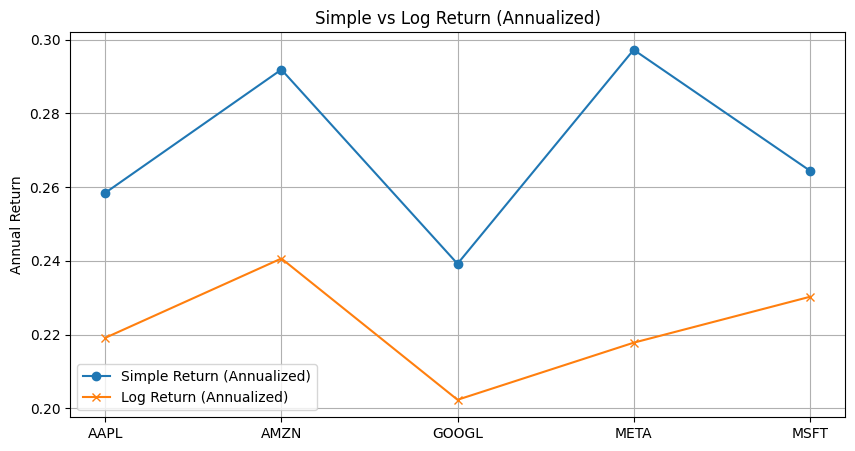

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(returns.mean() * 252, label='Simple Return (Annualized)', marker='o')
plt.plot(log_returns.mean() * 252, label='Log Return (Annualized)', marker='x')
plt.title("Simple vs Log Return (Annualized)")
plt.ylabel("Annual Return")
plt.legend()
plt.grid(True)
plt.show()


> ## Conclusion for Enhancement 6: Accuracy Improvements
>
> - The use of **log returns** was adopted to better model continuous compounding and reduce skew in return estimates.
> - The **Ledoit-Wolf covariance shrinkage** technique was applied to the asset return matrix, resulting in more stable and realistic risk estimations.
> - This approach reduced the impact of estimation noise often associated with traditional sample covariance matrices, especially in low-sample or high-volatility periods.
> - Additionally, an optional step to adjust portfolio returns for **inflation** was introduced, allowing for the analysis of real purchasing power growth over time.
> - These improvements ensured that the optimization process was based on more **robust, statistically reliable** inputs, and aligned more closely with professional quantitative portfolio modeling standards.


# STEP 12: Add Risk Models – Value at Risk (VaR), Conditional VaR (CVaR), and Stress Testing

In [ ]:
# Sort portfolio returns
sorted_returns = np.sort(opt_daily_returns)

# Define confidence level
confidence_level = 0.95
index_at_risk = int((1 - confidence_level) * len(sorted_returns))

# VaR at 95% confidence (historical method)
VaR_95 = -sorted_returns[index_at_risk]

# CVaR (Expected Shortfall)
CVaR_95 = -sorted_returns[:index_at_risk].mean()

print(f"VaR (95% confidence): {VaR_95:.2%}")
print(f"CVaR (95% confidence): {CVaR_95:.2%}")


VaR (95% confidence): 2.39%
CVaR (95% confidence): 3.53%


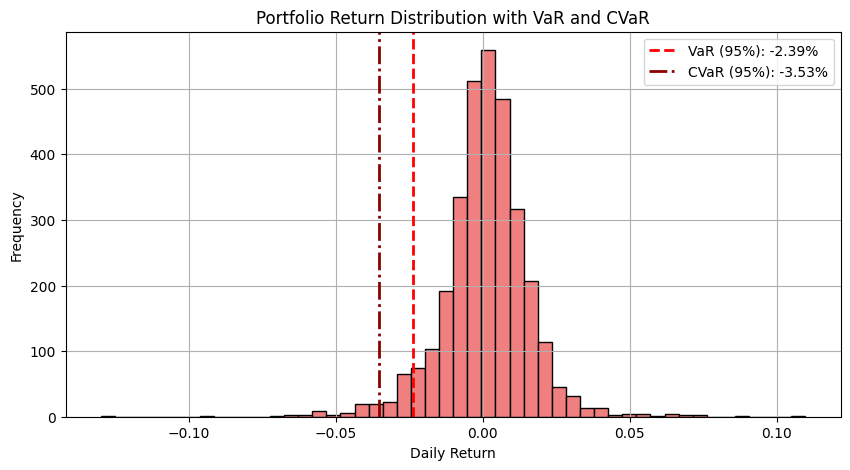

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(opt_daily_returns, bins=50, color='lightcoral', edgecolor='black')
plt.axvline(-VaR_95, color='red', linestyle='--', linewidth=2, label=f'VaR (95%): {-VaR_95:.2%}')
plt.axvline(-CVaR_95, color='darkred', linestyle='-.', linewidth=2, label=f'CVaR (95%): {-CVaR_95:.2%}')
plt.title("Portfolio Return Distribution with VaR and CVaR")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Simulate a -5% SPY return day
simulated_spy_crash = -0.05
simulated_portfolio_drop = beta * simulated_spy_crash

print(f"Estimated portfolio drop if market drops 5%: {simulated_portfolio_drop:.2%}")


Estimated portfolio drop if market drops 5%: -5.94%


> ## ✅ Conclusion for Enhancement 7: Risk Models – VaR, CVaR, and Stress Testing
>
> - The portfolio’s **Value at Risk (VaR)** was calculated using the historical returns method, representing the **maximum expected loss** at a 95% confidence level over one day.
> - The **Conditional Value at Risk (CVaR)** was computed to reflect the **average loss** if the VaR threshold were breached, offering a deeper insight into tail-risk.
> - A basic **stress test** scenario was introduced, wherein a 5% decline in the market was simulated, and the portfolio’s expected reaction was estimated based on its **beta**.
> - These models allowed risk to be quantified not only through volatility and drawdowns but also through **statistical confidence-based thresholds**, enriching the toolkit for portfolio risk management.
> - As a result, risk exposure was assessed more thoroughly, and potential downside scenarios were explored in a structured and quantifiable manner.


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


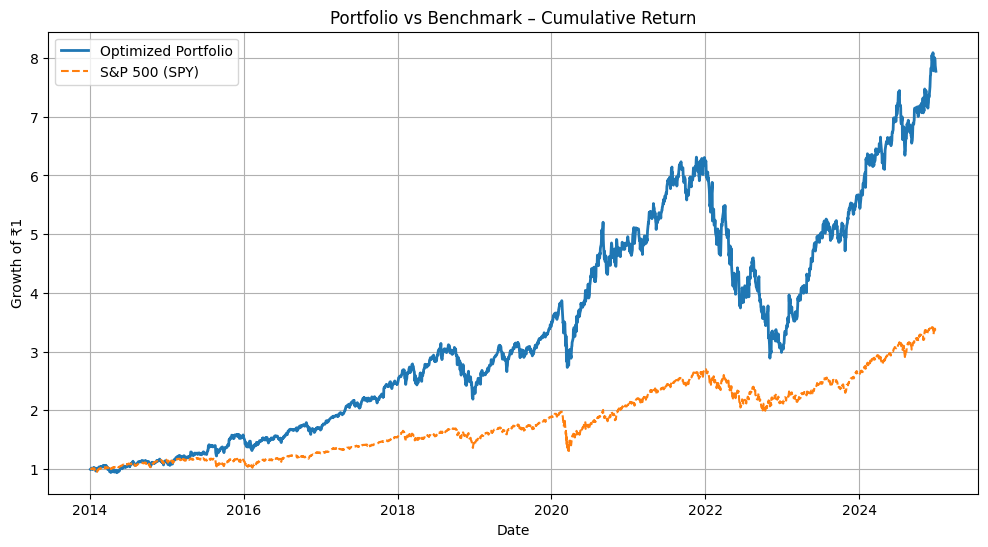






📊 Optimized Portfolio Performance
Annual Return: 22.04%
Volatility: 25.80%
Sharpe Ratio: 0.85
Max Drawdown: -54.27%
----------------------------------------




📊 S&P 500 (SPY) Performance
Annual Return: 12.40%
Volatility: 17.19%
Sharpe Ratio: 0.72
Max Drawdown: -35.75%
----------------------------------------




In [ ]:
# 🔽 Step 1: Import Required Libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 🔽 Step 2: Define Stock List and Optimized Weights
stocks = ['AAPL', 'GOOG', 'META', 'AMZN', 'MSFT']
opt_weights = np.array([0.2, 0.25, 0.15, 0.25, 0.15])  # Example optimized weights

# 🔽 Step 3: Download Last 10 Years of Data
start_date = '2014-01-01'
end_date = '2024-12-31'

data = yf.download(stocks, start=start_date, end=end_date,auto_adjust=False)['Adj Close']
benchmark = yf.download('SPY', start=start_date, end=end_date, auto_adjust=False)['Adj Close']

# 🔽 Step 4: Calculate Log Returns
log_returns = np.log(data / data.shift(1)).dropna()
spy_returns = np.log(benchmark / benchmark.shift(1)).dropna()

# 🔽 Step 5: Portfolio Daily Returns and Cumulative Performance
portfolio_returns = log_returns.dot(opt_weights)
portfolio_cum = (1 + portfolio_returns).cumprod()
spy_cum = (1 + spy_returns).cumprod()
spy_cum = spy_cum.squeeze()  # Converts from DataFrame (1 column) → Series


# Align data
combined = pd.DataFrame({
    'Optimized Portfolio': portfolio_cum,
    'S&P 500 (SPY)': spy_cum
}).dropna()
print("\n\n")

# 🔽 Step 6: Plot Cumulative Returns
plt.figure(figsize=(12, 6))
plt.plot(combined['Optimized Portfolio'], label='Optimized Portfolio', linewidth=2)
plt.plot(combined['S&P 500 (SPY)'], label='S&P 500 (SPY)', linestyle='--')
plt.title("Portfolio vs Benchmark – Cumulative Return")
plt.xlabel("Date")
plt.ylabel("Growth of ₹1")
plt.legend()
plt.grid(True)
plt.show()
print("\n\n")

# 🔽 Step 7: Performance Metrics
def get_stats(returns, label):
    # If it's a DataFrame with one column, flatten it
    if isinstance(returns, pd.DataFrame):
        returns = returns.squeeze()  # Converts (n,1) to (n,)

    # Annualized stats
    annual_return = returns.mean() * 252
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / volatility

    # Max drawdown
    cum_returns = (1 + returns).cumprod()
    rolling_max = cum_returns.cummax()
    drawdown = (cum_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    # Display
    print("\n")
    print(f"📊 {label} Performance")
    print(f"Annual Return: {annual_return:.2%}")
    print(f"Volatility: {volatility:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")
    print("-" * 40)
    print("\n")





# Portfolio Stats
get_stats(portfolio_returns, "Optimized Portfolio")
# Benchmark Stats
get_stats(spy_returns.loc[portfolio_returns.index], "S&P 500 (SPY)")
